In [11]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
import sys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from os import pardir
from glob import glob
from tqdm import tqdm
from hammer import dm
from scipy.interpolate import interp1d
from scipy.integrate import simps

In [2]:
curr_dir = abspath('')
root_dir = abspath(join(curr_dir, pardir))
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/2_Cleaning',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import concat

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir 

'/home2/s20321005/Thesis-Project/Data'

In [6]:
name = "Baryon"
data_dir = join(root_data_dir, name)
data_dir

'/home2/s20321005/Thesis-Project/Data/Baryon'

In [7]:
# load baryons components
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [8]:
def frho(phi, rho0, sigmaz):
    return rho0*np.exp(-phi/sigmaz**2)

def rhob_tot(phi, rhos, sigmaz):
    rho = np.array(list(map(lambda par: frho(phi, par[0], par[1]), zip(rhos, sigmaz))))
    return rho.sum(axis=0)

In [9]:
rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhoDM = 0.02 # Msun/pc^3

Find at what $\Phi(z)$ the value of baryonic mass density $\rho_b$ is equal to the dark matter density $\rho_{\textup{DM}}$.

\begin{align*}
    \frac{\rho_b}{\rho_{\textup{DM}}} = \frac{\sum \rho_{b,i}(z)}{\rho_{\textup{DM}}} &= 1\\
    

\end{align*}

323.3123312331233

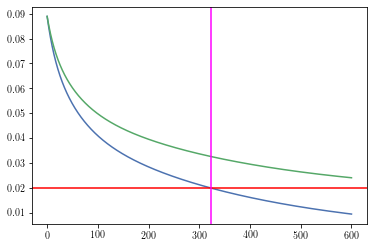

In [10]:
phis = np.linspace(0, 600, 10000)
rhobz = rhob_tot(phis, rhob, sigmaz)
arg =np.argmin(np.abs(rhobz-rhoDM))
phi_b = phis[arg]
plt.plot(phis, rhobz)
plt.plot(phis, (rhobz+rhoDM)/(rhobz[0]+rhoDM)*rhobz[0])
plt.axhline(rhoDM, color="red")
plt.axvline(phi_b, color="magenta")
phi_b

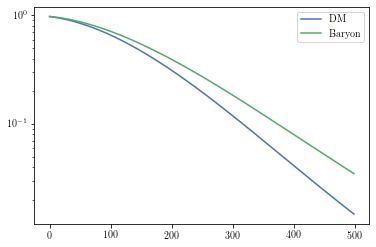

In [13]:
rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhoDM = 0.02
# rhob = rhob*(1+rhoDM/np.sum(rhob))
log_nu0 = 0
R = 3.4E-3
zsun = 30

theta_dm = concat(rhob, sigmaz, rhoDM, log_nu0, R, zsun)

rhoDM = 0.0
rhob = rhob*(1+rhoDM/np.sum(rhob))
theta_b = concat(rhob, sigmaz, rhoDM, log_nu0, R, zsun)

w0 = -7.
sigma1 = 10.
sigma2 = 15.
log_sigmaw = np.log(sigma1)
q_sigmaw = sigma1/sigma2
a1 = 0.9
a2 = 0.1
log_a = np.log(a1)
q_a = a2/a1

psi = concat(w0, log_sigmaw, q_sigmaw, log_a, q_a)

dz = 1.
z = np.arange(0, 500, dz)
plt.plot(z, dm.fz(z, theta_dm, psi, dz), label="DM")
plt.plot(z, dm.fz(z, theta_b, psi, dz), label="Baryon")
plt.yscale("log")
plt.legend()
plt.show()

In [14]:
log_nu0 = 0
R = 3.4E-3
zsun = 0

theta = concat(rhob, sigmaz, rhoDM, log_nu0, R, zsun)

# integration limits
z_start = 0
z_end = 1200
dz = 0.1
z = np.arange(z_start, z_end, dz)
phi = dm.potential(z, theta, dz)
z_interp = interp1d(phi, z, kind="cubic")
zb = z_interp(phi_b)
arg_z = np.argmin(np.abs(z-zb))
zb, arg_z

(array(465.59465193), 4656)